# Stepped Impedance Design

This design is done using a 3rd-order Chebyshev I type filter, with a maximum ripple in the passband of 0.1dB, in accordance with Microstrip Filters for RF/Micowave Applications by Jia-Sheng Hong.
<br>
Much of the difficult work obtaining equations is from the aforementioned Microstrip Filters for RF/Micowave Applications by Jia-Sheng Hong. I highly recommend reading it to truly understand the construction of microstrip filters of any kind.
<br>
Notebook written by Ethan Kasaba.
<br>
Revision 1.1

## Imports

In [9]:
from scipy import signal
from scipy.optimize import fsolve
import numpy as np 
import matplotlib.pyplot as plt

## Variables That Can Be Changed

In [10]:
cutoff = 2.5 * 10 ** 9 # cutoff frequency (Hz)

#Change these values to match your substrate, and the characteristic impedances of the low- and high-impedance lines
epsilon = 10.8 # relative permittivity of substrate
h = 1.4 # substrate thickness (mm)
z0c = 24 # desired characteristic impedance of low-impendance (capacitive) lines (ohms), 24 ohms chosen based on Hong
z0l = 93 # desired characteristic impedance of high-impendance (inductive) lines (ohms), 93 ohms chosen based on Hong

## Variables That Should Not Be Changed

In [11]:
ord = 3 # order, number of reactive elements in the filter
# Note that the order may be changed to get the g's, but the length calculations have yet to be generalized to other orders
rip = 0.1 # maximum ripple (dB) in pass band
# The same applies to the ripple, it may be changed to obtain g's, but the length calculations have yet to be generalized to other ripple values
cutoffGHz = cutoff / (10 ** 9) # cutoff frequency conversion (GHz)
cutoffrads = 2 * np.pi * cutoff # cutoff frequency conversion (rads/sec)
g0 = 1 # source impedance, normalized to 1 typically
z0 = 50 # characteristic impedance (ohms), usually 50 ohms for microwave applications
type = 'low' # type of filter: low-pass, this is for the plotting

## Plotting Expected Transfer Function

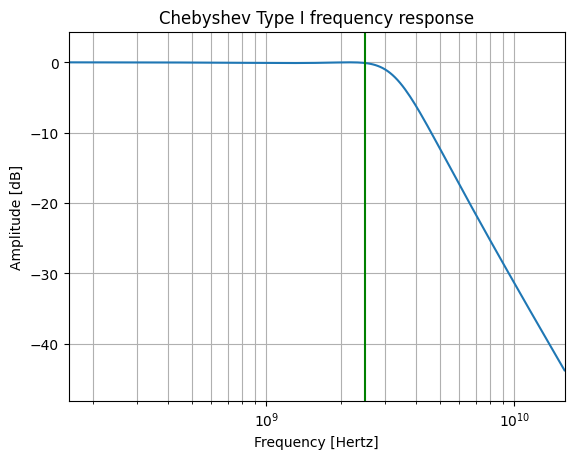

In [12]:
b, a = signal.cheby1(ord, rip, cutoffrads, type, analog=True) # get filter coefficients for plotting
w, x = signal.freqs(b, a) # frequency response for plotting
plt.semilogx(w / (2 * np.pi), 20 * np.log10(abs(x))) # plot frequency response
plt.title('Chebyshev Type I frequency response')
plt.xlabel('Frequency [Hertz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green') # cutoff frequency line in green
plt.show()

## Finding the Element Values

In [13]:
beta = np.log(1/np.tanh(rip / 17.37)) # phase constant/beta value for Chebyshev response, Hong p. 41
gamma = np.sinh(beta / (2 * ord)) # propagation constant/gamma value for Chebyshev response, Hong p. 41
gs = np.zeros(ord + 2) # g values for Chebyshev response
for i in range(ord + 2):
    if i == 0:
        gs[i] = 1 # g0 value for Chebyshev response, see variables that should not be changed above
    elif i == 1:
        gs[i] = (2 / gamma) * np.sin(np.pi / (2 * ord)) # g1 value for Chebyshev response, Hong p. 41
    elif i <= ord:
        gs[i] = (1 / gs[i - 1]) * (4 * np.sin((2 * i - 1) * np.pi / (2 * ord)) * np.sin((2 * i - 3) * np.pi / (2 * ord))) / (gamma ** 2 + (np.sin(((i - 1) * np.pi) / ord) ** 2)) # g n value for Chebyshev response, Hong p. 41 (3.26)
    else:
        if ord % 2 == 0:
            gs[i] = (1 / np.tanh(beta / 4)) ** 2 # g n+1 value for Chebyshev response, Hong p. 41
        else:
            gs[i] = 1 # g n+1 value for Chebyshev response, Hong p. 41

## Element Calculation

In [14]:
def inductancefromg(z0, g0, f, g): # Gets inductance from g value, Hong p. 114 (5.1)
    return (z0/g0) * (1/(2*np.pi*f)) * g
def capacitancefromg(z0, g0, f, g): # Gets capacitance from g value, Hong p. 114 (5.1)
    return (g0/z0) * (1/(2*np.pi*f)) * g

element = 1 # element number, skipping 0, the source impedance
elements = [] # inductances and capacitances of each element
for g in gs: # iterate through g values, obtain inductance or capacitance
    if g == 1:
        continue
    elif element % 2 == 1:
        out = inductancefromg(z0, g0, cutoff, g)
        print("L" + str(element) +  " = ", out)
    else:
        out = capacitancefromg(z0, g0, cutoff, g)
        print("C" + str(element) +  " = ", out)
    element += 1
    elements.append(out)
L = elements[0] # inductance of first and third element, in the the 3rd order case
C = elements[1] # capacitance of second element

L1 =  3.283637493005715e-09
C2 =  1.4609154737392528e-12
L3 =  3.283637493005715e-09


## Finding the Element Lengths, Only Works for 3rd Order, 0.1dB ripple

In [16]:
def findulessthan2(ep, z): # finds ratio of width to height when w/h <= 2, done for inductor and source impedence
    A = (z / 60) * ((ep + 1) / 2) ** 0.5 + ((ep - 1) / (ep + 1)) * (0.23 + 0.11 / epsilon) # Used in next declaration, Hong p. 79
    return 8 * np.exp(A) / (np.exp(2 * A) - 2) # Hong p. 79 (4.10)

def findumorethan2(ep, z): # finds ratio of width to height when w/h >= 2, done for capacitor
    B = (60 * np.pi ** 2) / (z * np.sqrt(ep)) # Used in next declaration, Hong p. 79
    return (2 / np.pi) * (B - 1 - np.log(2 * B - 1) + ((ep - 1) / (2 * ep)) * (np.log(B - 1) + 0.39 - 0.61 / ep)) # Hong p. 79 (4.11)

def effepsilon(ep, u): # finds effective permittivity, Hong p. 78 (4.4)
    a = 1 + 1/49 * np.log((u ** 4 + (u / 52) ** 2) / (u ** 4 + 0.432)) + 1/18.7 * np.log(1 + (u / 18.1) ** 3)
    b = 0.564 * ((ep - 0.9) / (ep + 3)) ** 0.053
    return ((ep + 1) / 2) + ((ep - 1) / 2) * ((1 + 10 / u) ** (-a * b))
effepsilonL = effepsilon(epsilon, findulessthan2(epsilon, z0l)) # effective permittivity, for inductor
effepsilonC = effepsilon(epsilon, findumorethan2(epsilon, z0c)) # effective permittivity, for capacitor
effepsilon0 = effepsilon(epsilon, findulessthan2(epsilon, z0)) # effective permittivity, for source impedance

def findlambda(cutoff, effepsilon): # find guided wavelength, Hong p. 77 (4.6b)
    return 300 / ((cutoff) * np.sqrt(effepsilon)) # guided wavelength (mm)
lambdal = findlambda(cutoffGHz, effepsilonL) # guided wavelength for inductor (mm)
lambdac = findlambda(cutoffGHz, effepsilonC) # guided wavelength for capacitor (mm)
lambda0 = findlambda(cutoffGHz, effepsilon0) # guided wavelength for source impedance (mm)

def func(x): # system of equations to solve for x = [lL, lC], Hong p. 114
    return [z0l * np.sin((2 * np.pi * x[0]) / lambdal) + z0c * np.tan((np.pi * x[1]) / lambdac) - cutoffrads * L,
            (1 / z0c) * np.sin((2 * np.pi * x[1]) / lambdac) + (2 / z0l) * np.tan(np.pi * x[0] / lambdal) - cutoffrads * C]
lengths = fsolve(func, [0.01, 0.01]) # solve for lL and lC, the lengths of the inductive and capacitive elements, respectively

i = 0 # counter for printing out lengths
for length in lengths: # print out lengths of inductive and capacitive elements
    if i % 2 == 0:
        print("The lengths of the inductive elements are: " + str(length) + " mm")
    else:
        print("The lengths of the capacitive elements are: " + str(length) + " mm")
    i += 1
# print("The guided wavelength for the inductive elements is: " + str(lambdal) + " mm")
# print("The guided wavelength for the capacitive elements is: " + str(lambdac) + " mm")
# print("The guided wavelength for the source impedance is: " + str(lambda0) + " mm")

The lengths of the inductive elements are: 3.8957637806919028 mm
The lengths of the capacitive elements are: 2.8549063576776073 mm


## Finding the Element Widths, Same as Above

In [8]:
w0 = h * findulessthan2(epsilon, z0) # width of source impedance (mm)
wl = h * findulessthan2(epsilon, z0l) # width of high-impedance line (mm)
wc = h * findumorethan2(epsilon, z0c) # width of low-impedance line (mm)

print("The widths of the inductive elements are: " + str(wl) + " mm")
print("The widths of the capacitive elements are: " + str(wc) + " mm")
# print("The width of the source impedance is: " + str(w0) + " mm")

The widths of the inductive elements are: 0.21272005067174096 mm
The widths of the capacitive elements are: 4.3395632556119805 mm
